In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [148]:
from datetime import timedelta

In [2]:
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, recall_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization
import pandas as pd
import pandas as pd
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN
from collections import Counter
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN
from collections import Counter
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.pipeline import Pipeline
from langdetect import detect
import re
import string
import contractions
import unicodedata
from langdetect import detect
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import spacy
import nltk

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')


try:
    nlp_en = spacy.load("en_core_web_sm")
except Exception as e:
    print("Please install the spaCy English model: en_core_web_sm")
try:
    nlp_de = spacy.load("de_core_news_md")
except Exception as e:
    print("Please install the spaCy German model: de_core_news_sm")



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def extract_all_text_features(text_series, lang='en'):
    """
    Extract comprehensive text features including both basic metrics and advanced readability scores.

    Parameters:
    -----------
    text_series : pandas.Series()
        Series containing text data
    lang : str, default='en'
        Language model to use ('en' or 'de')

    Returns:
    --------
    pandas.DataFrame()
        DataFrame with all text features
    """
    # Initialize the DataFrame to store all features
    features_df = pd.DataFrame(index=text_series.index)

    # Load appropriate spaCy model
    try:
        if lang == 'en':
            nlp = spacy.load("en_core_web_md")
        elif lang == 'de':
            nlp = spacy.load("de_core_news_sm")
        else:
            nlp = spacy.load("en_core_web_md")
    except OSError:
        print(f"spaCy model for language '{lang}' not found. Installing fallback model...")
        from spacy.cli import download
        try:
            download("en_core_web_md")
            nlp = spacy.load("en_core_web_md")
        except:
            print("Failed to download model. Using blank model instead.")
            nlp = spacy.blank("en")

    text_series = text_series.fillna("")
    # Basic text features
    features_df['feat_text_length'] = text_series.str.len().fillna(0)
    features_df['feat_word_count'] = text_series.apply(lambda x: len(str(x).split()) if len(x)>2 else 0)
    features_df['feat_unique_word_count'] = text_series.apply(lambda x: len(set(str(x).split())) if len(x)>2 else 0)
    features_df['feat_avg_word_length'] = text_series.apply(
        lambda x: np.mean([len(w) for w in str(x).split()]) if len(str(x).split()) > 1 else 0
    )

    # Character-level features
    features_df['feat_char_count_no_spaces'] = text_series.apply(
        lambda x: sum(1 for char in str(x) if char not in [' ', '\t', '\n'])
    )

    # Additional basic features
    features_df['feat_word_density'] = features_df['feat_word_count'] / features_df['feat_text_length'].replace(0, 1)
    features_df['feat_unique_word_ratio'] = features_df['feat_unique_word_count'] / features_df['feat_word_count'].replace(0, 1)

    # Process each text for advanced readability metrics
    for idx, text in text_series.items():
        # Skip empty texts
        if not text or not isinstance(text, str) or text.strip() == "":
            continue

        # Process with spaCy
        doc = nlp(text)

        # Count words, sentences, syllables, characters, and complex words
        word_count = sum(1 for token in doc if not token.is_punct and not token.is_space)
        sentence_count = len(list(doc.sents))
        punctuations_count = sum(1 for token in doc if token.is_punct)
        if punctuations_count is None or pd.isna(punctuations_count):
            print(11)
        # Skip if no words or sentences
        if word_count == 0 or sentence_count == 0:
            continue

        # Count syllables and complex words
        syllable_count = 0
        complex_word_count = 0  # Words with 3+ syllables
        verb_counts = 0

        for token in doc:
            if token.is_punct or token.is_space:
                continue
            if token.pos_=='VERB':
                verb_counts+=1
                
            word = token.text.lower()
        
            # Count syllables (English-specific approximation)
            if lang == 'en':
                # Remove non-alphabetic characters
                word = re.sub(r'[^a-zA-Z]', '', word)

                # Count syllables based on vowel sequences
                count = 0
                vowels = "aeiouy"

                # Special cases
                if word.endswith('e'):
                    word = word[:-1]

                if word.endswith('le') and len(word) > 2 and word[-3] not in vowels:
                    count += 1

                # Count vowel sequences
                prev_is_vowel = False
                for char in word:
                    is_vowel = char in vowels
                    if is_vowel and not prev_is_vowel:
                        count += 1
                    prev_is_vowel = is_vowel

                # Ensure at least one syllable per word
                if count == 0 and len(word) > 0:
                    count = 1

                syllable_count += count

                # Complex words (3+ syllables)
                if count >= 3:
                    complex_word_count += 1
            else:
                # For non-English languages, use a simpler approximation
                syllable_count += max(1, len(re.findall(r'[aeiouäöüáéíóúàèìòù]+', word)))
                if len(re.findall(r'[aeiouäöüáéíóúàèìòù]+', word)) >= 3:
                    complex_word_count += 1

        # Character count (excluding spaces)
        char_count = sum(len(token.text) for token in doc if not token.is_space)

        # Add sentence count and syllable count as features
        features_df.loc[idx, 'feat_sentence_count'] = sentence_count
        features_df.loc[idx, 'feat_syllable_count'] = syllable_count
        features_df.loc[idx, "feat_verb_counts"] = verb_counts
        features_df.loc[idx, 'feat_punctuations_count'] = punctuations_count
        features_df.loc[idx, 'feat_complex_word_count'] = complex_word_count
        features_df.loc[idx, 'feat_syllables_per_word'] = syllable_count / word_count
        features_df.loc[idx, 'feat_words_per_sentence'] = word_count / sentence_count

        # Calculate average values
        words_per_sentence = word_count / sentence_count
        syllables_per_word = syllable_count / word_count
        chars_per_word = char_count / word_count

        # Calculate readability scores

        # 1. Flesch Reading Ease Score
        flesch_reading_ease = 206.835 - (1.015 * words_per_sentence) - (84.6 * syllables_per_word)
        flesch_reading_ease = max(0, min(100, flesch_reading_ease))  # Clamp to 0-100
        features_df.loc[idx, 'feat_flesch_reading_ease'] = round(flesch_reading_ease, 2)

        # 2. Flesch-Kincaid Grade Level
        flesch_kincaid_grade = (0.39 * words_per_sentence) + (11.8 * syllables_per_word) - 15.59
        flesch_kincaid_grade = max(0, flesch_kincaid_grade)  # Ensure non-negative
        features_df.loc[idx, 'feat_flesch_kincaid_grade'] = round(flesch_kincaid_grade, 2)

        # 3. Gunning Fog Index
        gunning_fog = 0.4 * (words_per_sentence + 100 * (complex_word_count / word_count))
        features_df.loc[idx, 'feat_gunning_fog'] = round(gunning_fog, 2)

        # 4. SMOG Index
        if sentence_count >= 30:
            smog_index = 1.043 * math.sqrt(complex_word_count * (30 / sentence_count)) + 3.1291
        else:
            # Adjusted formula for texts with fewer than 30 sentences
            smog_index = 1.043 * math.sqrt(complex_word_count * (30 / max(1, sentence_count))) + 3.1291
        features_df.loc[idx, 'feat_smog_index'] = round(smog_index, 2)

        # 5. Coleman-Liau Index
        l = (char_count / word_count) * 100  # Average number of characters per 100 words
        s = (sentence_count / word_count) * 100  # Average number of sentences per 100 words
        coleman_liau_index = max(0.0588 * l - 0.296 * s - 15.8, 0)
        features_df.loc[idx, 'feat_coleman_liau_index'] = round(coleman_liau_index, 2)

        # 6. Automated Readability Index (ARI)
        automated_readability_index = 4.71 * chars_per_word + 0.5 * words_per_sentence - 21.43
        automated_readability_index = max(0, automated_readability_index)  # Ensure non-negative
        features_df.loc[idx, 'feat_automated_readability_index'] = round(automated_readability_index, 2)

        # 7. Dale-Chall Readability Formula (simplified version)
        dale_chall_readability = 0.1579 * (complex_word_count / word_count * 100) + 0.0496 * words_per_sentence
        if complex_word_count / word_count > 0.05:
            dale_chall_readability += 3.6365  # Adjustment for texts with many complex words
        features_df.loc[idx, 'feat_dale_chall_readability'] = round(dale_chall_readability, 2)

    # Fill NaN values with appropriate defaults
    readability_columns = [
            'feat_flesch_reading_ease', 'feat_flesch_kincaid_grade', 'feat_gunning_fog', 'feat_smog_index',
            'feat_coleman_liau_index', 'feat_automated_readability_index', 'feat_dale_chall_readability',
            'feat_sentence_count', 'feat_syllable_count', 'feat_complex_word_count', 'feat_syllables_per_word',
            'feat_words_per_sentence'
    ]

    for col in readability_columns:
        if col in features_df.columns:
            features_df[col] = features_df[col].fillna(0)

    return features_df.fillna(0)

In [4]:
pd.set_option('display.max_columns', None)


In [5]:
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder



def preprocess_is_meeting_with_advisor(dataframe):
    

    dataframe['feat_in_contact_with_job_advisor'] = dataframe['in_contact_with_job_advisor'].str.lower().fillna('unspecified')
    
    
    return dataframe


def preprocess_visa_status(dataframe):
    
    def normalize_status(current_status):
        if pd.isna(current_status):
            return ":unknown"
        
        working_status = str(current_status).lower().split("(")[0]
        if working_status.find("eu citi") > -1:
            return "eu citizen"
        if working_status.find("ständiger wohnsitz") > -1 or working_status.find("permanent resident") > -1:
            return "permanent resident"
        if working_status.find("eu blue card") > -1 or working_status.find("blaue karte") > -1:
            return "eu blue card"
        if working_status.find("24") > -1:
            return "paragraph 24"
        if working_status.find("asylum") > -1 or working_status.find("24") > -1:
            return "asylum seeker"
        if working_status.find("temporary stay") > -1 or working_status.find("aufenthaltserlaubnis") > -1:
            return "temporary stay permit"
        
        if working_status.find("work visa") > -1:
            return "work visa"
        
        if working_status.find("student visa") > -1:
            return "student visa"
        if working_status.find("famil") > -1:
            return "family reunification"
        
        if working_status.find("job seeker") > -1:
            return "job seeker visa"
        
        if working_status.find("other") > -1:
            return ":other"
        return ":other"
    
    dataframe['feat_visa_status'] = dataframe['status'].apply(normalize_status)
    
    return dataframe



def preprocess_mql_hour_minutes_features(df, datetime_column, drop_original=True):
    """
    Creates cyclical features from a datetime column and adds a single projection feature.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the datetime column
    datetime_column : str
        Name of the datetime column
    drop_original : bool, default=True
        Whether to drop the original datetime column
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with cyclical features added
    """
    # Make a copy to avoid modifying the original
    df_result = df.copy()
    
    # Convert to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(df_result[datetime_column]):
        df_result[datetime_column] = pd.to_datetime(df_result[datetime_column])
    
    # Extract time components
    df_result['hour'] = df_result[datetime_column].dt.hour
    df_result['day'] = df_result[datetime_column].dt.day
    df_result['month'] = df_result[datetime_column].dt.month
    df_result['day_of_week'] = df_result[datetime_column].dt.dayofweek
    
    # Create cyclical features
    
    # Hour of day (24-hour cycle)
    df_result['hour_sin'] = np.sin(2 * np.pi * df_result['hour'] / 24)
    df_result['hour_cos'] = np.cos(2 * np.pi * df_result['hour'] / 24)
    df_result['feat_hour_projection'] = (df_result['hour_sin'] + df_result['hour_cos']) / np.sqrt(2)
    
    # Day of month (assuming 31 days max)
    df_result['day_sin'] = np.sin(2 * np.pi * df_result['day'] / 31)
    df_result['day_cos'] = np.cos(2 * np.pi * df_result['day'] / 31)
    df_result['feat_day_projection'] = (df_result['day_sin'] + df_result['day_cos']) / np.sqrt(2)
    
    # Month of year (12-month cycle)
    df_result['month_sin'] = np.sin(2 * np.pi * df_result['month'] / 12)
    df_result['month_cos'] = np.cos(2 * np.pi * df_result['month'] / 12)
    df_result['feat_month_projection'] = (df_result['month_sin'] + df_result['month_cos']) / np.sqrt(2)
    
    # Day of week (7-day cycle)
    df_result['day_of_week_sin'] = np.sin(2 * np.pi * df_result['day_of_week'] / 7)
    df_result['day_of_week_cos'] = np.cos(2 * np.pi * df_result['day_of_week'] / 7)
    df_result['feat_day_of_week_projection'] = (df_result['day_of_week_sin'] + df_result['day_of_week_cos']) / np.sqrt(2)
    
    # Drop intermediate columns if needed
    if drop_original:
        df_result = df_result.drop(['hour', 'day', 'month', 'day_of_week'], axis=1)
    
    return df_result


def preprocess_age_ranges(dataframe):
    dataframe = dataframe.dropna(subset=["age_range"]).copy()
    dataframe = dataframe[~dataframe['age_range'].str.contains(";")].copy()
    
    dataframe['age_range'] = dataframe['age_range'].replace({"32": "25-40"})
    dataframe['age_range'] = np.where(dataframe['age_range'] == '16-22', "16-21", dataframe['age_range'])

    dataframe['feat_age_range'] = dataframe['age_range']
    
    return dataframe



def preprocess_utm_source(source_col):
    if pd.isna(source_col):
        return "unknown"
    if source_col in ("google", 'adwords'):
        return "google"
    if source_col.startswith("ig"):
        return "instagram"
    if source_col.lower() in ("fb", "facebook", "meta") or source_col.startswith("fb"):
        return "facebook"
    if source_col in ("website", "webiste","Landing Page","campus"):
        return "ms_property"
    if source_col.find("source")>-1:
        return "unknown"
    if source_col in ("newsletter", "email", "hs_automation", "hs_email"):
        return "email"
    if source_col.lower()=='whatsapp':
        return source_col.lower()
    return "other"
    
    
def preprocess_utm_medium(medium_col):
    if pd.isna(medium_col):
        return "unknown"
    
    medium_col = medium_col.lower()
    if medium_col in ("cpc", "paid", "ppc", "paid\t"):
        return "paid"
    
    if medium_col.find("utm_medium")>-1:
        return "unknown"
    if medium_col.find("organic")>-1:
        return "organic"
    if "direct" in medium_col:
        return "direct"
    if "social" in medium_col:
        return "social"
    if 'niklas' in medium_col or 'leonidas' in medium_col or "cedric" in medium_col:
        return "influencer"
    return "unknown"
    

def preprocess_all_data_ad_name(dataframe):
    dataframe['ad_name'] = dataframe['ad_name'].str.lower().str.strip()
    pattern = re.compile(r'\[(?P<key>type|usp|prog|3s):(?P<value>[^\]]+)\]')

    def normalizing_ad_type(type_):
        if pd.isna(type_):
            return "not specified"
        if "mage" in type_:
            return "image"
        if "carou" in type_:
            return "carousel"
        if "vid" in type_:
            return "video"
        return type_

    def program_in_ad_imputer(program):
        if pd.isna(program):
            return "not specified"
        if 'data' in program or program == 'date':
            return 'da'
        if program.startswith("_") or program.startswith(":"):
            return program[1:].replace("-", " ")

        return program.replace("-", " ")
    def extract_selected_keys(ad_name):
        """Extract type, usp, and prog from the ad_name string and return them as a dictionary."""
        matches = pattern.finditer(ad_name)
        return {m.group('key'): m.group('value').strip('_') for m in matches}

    # Apply function to ad_name column and create a DataFrame from the dictionaries
    extracted_df = dataframe['ad_name'].apply(lambda x: pd.Series(extract_selected_keys(x), dtype='object'))
    extracted_df['feat_usp'] = extracted_df['usp'].fillna("not specified")
    extracted_df['feat_3s'] = extracted_df['3s'].fillna("not specified")
    extracted_df['feat_type'] = extracted_df['type'].fillna("not specified").apply(normalizing_ad_type)
    extracted_df['feat_prog'] = extracted_df['prog'].fillna("not specified").apply(program_in_ad_imputer)
    # Join the new columns to the original DataFrame
    dataframe = dataframe.join(extracted_df)

    return dataframe


In [6]:
new_df = pd.read_csv('base_data.tsv', sep="\t", index_col='id')

C:\Users\Tal\AppData\Local\Temp\ipykernel_26132\281279912.py:1: DtypeWarning: Columns (3,6,12,18,26,36) have mixed types. Specify dtype option on import or set low_memory=False.
  new_df = pd.read_csv('base_data.tsv', sep="\t", index_col='id')


In [7]:
new_df.columns = [x.split("bg0__")[1] if "bg0__" in x else x for x in [x.replace("bg__", "") .split("properties_")[1] if "properties_" in x else x for x in new_df.columns ]]

In [8]:
new_df['requested_bg_date'] = pd.to_datetime(new_df['requested_bg_date'])
new_df[new_df['requested_bg_date']>'2024-12-01']

,age_range,employment_situation,german_job_permit,english_level,german_level,form_language,highest_level_of_education,how_did_you_hear_about_us,in_contact_with_job_advisor,last_job,preferred_cohort,program_length,registered_with_the_jobcenter,state,status,time_worked_in_de,field_of_interest,field_of_interest_2,residents,createdate,requested_bg_date,requested_bg,mql_date,sql_date,got_sql,bg_enrolled_date,lpvariant,utm_campaign,utm_content,utm_id,utm_medium,utm_source,utm_term,students_time_to_graduation,why_do_you_want_to_start_a_career_in_tech,closed_won_deal__program_duration
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
245324842,25-40,Unemployed,NaN,C1 - Advanced,B1 - Intermediate,NaN,Bachelor degree,Facebook / Instagram,NaN,Construction,NaN,NaN,No,Nordrhein-Westfalen,"Family reunification visa (""Familiennachzug"")",I haven't worked in Germany,Data Analytics,NaN,NaN,2023-09-12T21:45:13.639Z,2024-12-13,requested,2023-10-31T09:10:32.368Z,2024-12-12T09:25:16.426Z,sql,2024-12-16T07:35:56.490Z,NaN,23858447476950402,23858447476960402,[ini:New_CTA_LP]_[plt:_Meta]_[cou:DE]_[cjo:_Se...,paid,fb,23858447476940402,NaN,I have a great interest in this program,14 Months
247413357,25-40,Unemployed,NaN,Mother tongue,A1 - Beginner,NaN,Bachelor degree,Friend or family,NaN,Education,July 2024,NaN,Not yet,Nordrhein-Westfalen,"Family reunification visa (""Familiennachzug"")",6-12 months,Cloud Engineering,NaN,NaN,2023-09-21T10:34:00.114Z,2025-01-27,requested,2023-09-21T10:34:04.127Z,2023-09-26T18:53:48.470Z,sql,NaN,NaN,20939917833,687853865477,20939917833,paid,google,study cyber security,NaN,Because I want something more challenging yet ...,NaN
265149109,25-40,Employed,NaN,B2 - Upper-intermediate,A2 - Pre-intermediate,NaN,High school diploma,Search engine,"Yes, I have had a meeting with a job advisor",Marketing,January 2024 Class,NaN,Yes,Mecklenburg-Vorpommern,EU citizen (including Germany),More than 12 months,Data Analytics,NaN,NaN,2023-12-08T09:26:53.724Z,2024-12-02,requested,2023-12-08T09:27:57.739Z,2024-11-07T16:39:57.924Z,sql,2024-12-02T16:53:58.429Z,NaN,utm_campaign,285420108,20374398137,email,hs_automation,utm_term,NaN,"When I was Head of Marketing, I was pushed to ...",14 Months
270600112,56-64,Soon to be Unemployed,NaN,advanced (c1-c2),mother tongue,NaN,Bachelor degree,Search engine,Not yet,Marketing,March 2024,NaN,Yes,NaN,eu citizen,NaN,Data Analytics,NaN,NaN,2024-01-04T12:55:22.884Z,2025-01-02,requested,2024-01-04T12:56:54.729Z,2024-12-05T09:49:04.945Z,sql,2025-02-03T14:34:02.603Z,NaN,20668463669,678194175063,20668463669,paid,google,NaN,NaN,I am numbers driven guy,14 Months
274532886,41-55,Unemployed,NaN,advanced (c1-c2),beginner (a1-a2),en,High school diploma,Jobcenter or Agentur für Arbeit,Not yet,IT,September 2024,NaN,Yes,Niedersachsen,"temporary stay permit (""aufenthaltsgestattung"")",I haven't worked in Germany,Data Analytics,NaN,NaN,2024-01-20T11:58:17.753Z,2025-01-08,requested,2025-01-05T19:15:09.927Z,2025-01-07T12:48:23.947Z,sql,NaN,/data-analytics-germany-bg,120213968333100025,120215020047700025,[tgt:_BAU_EN_Broad_CBO_Nov]_[prog:_Gen]_[lng:_...,paid,fb,120215019688800025,NaN,I already have deep knowledge,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101786587564,25-40,Soon to be unemployed,NaN,Advanced (C1-C2),Beginner (A1-A2),en,NaN,NaN,"Yes, I have a scheduled date for my next meeting.",NaN,NaN,NaN,Yes,NaN,"Work visa (""Arbeitserlaubnis"")",More than 12 months,Data Analytics,NaN,NaN,2025-02-24T13:43:57.846Z,2025-02-25,requested,2025-02-24T13:44:46.075Z,2025-02-24T16:22:21.604Z,sql,NaN,/cybersecurity-germany-bg,21137642554,707479015161,21137642554,paid,google,cyber certifications,NaN,NaN,NaN
84453297540,41-55,Unemployed,NaN,intermediate (b1-b2),intermediate (b1-b2),en,High school diploma,Youtube,"Yes, I have had a meeting with a job advisor",IT,NaN,NaN,Yes,Berlin,EU Blue Card,6-12 months,Cybersecurity,NaN,NaN,2024-12-13T07:06:

In [9]:
def norm_employment(status):
    status_str = str(status).lower().strip()
    unemployed_cond = [status_str.find("unempl") > -1,status_str.find('retired')>-1,]
    long_break_cond = [status_str.find("wife")>-1
                       ,status_str.find("leave")>-1, status_str.find("ausfrau")>-1,
                       status_str.find('elternzeit')>-1, status_str.find("home")>-1, status_str.find('mom')>-1,
                      status_str.find('mother')>-1,]
    if any(unemployed_cond):
        return "unemployed"
    if any(long_break_cond):
        return "long_break"
    if status_str.find("self") > -1 or status_str.find("freel") > -1 or status_str.find("selbstst")>-1:
        return "freelance"
    if status_str.find("employed") > -1 or status_str.find('pair')>-1 or status_str.find("worker")>-1:
        return "employed"
    if status_str.find("train") > -1 or status_str.find("azub") > -1 or status_str.find("appre") > -1:
        return "trainee"
    if status_str.find("mini") > -1 or status_str.find("part") > -1 or status_str.find("intern") > -1:
        return "trainee"
    if status_str.find("student") > -1:
        return "student"
    if status_str.find("refugee")>-1 or status_str.find("asyl")>-1 or status_str.find("24")>-1:
        return "refugee"
    if status_str.find("usbildung") > -1:
        return "training"
    if status_str=="sonstiges" or status_str=="other":
        return "other"
    return "other"
    
    dataframe['employment_status'] = dataframe['employment_status'].apply(norm_employment)
    return dataframe


def clean_preferred_cohort(cohort_series):
    # Standardize German months to English
    month_mapping = {
        "Januar": "January",
        "Februar": "February",
        "März": "March",
        "Mai": "May",
        "Juni": "June",
        "Juli": "July",
        "Oktober": "October",
        "Dezember": "December"
    }
    
    # Replace German month names
    cohort_series = cohort_series.replace(month_mapping, regex=True)

    # Remove words like "Class" and extra spaces
    cohort_series = cohort_series.str.replace(r' Class', '', regex=True).str.strip()
    
    # Fix abbreviated months (e.g., 'Jan 2025' -> 'January 2025')
    cohort_series = cohort_series.replace({
        "Jan ": "January ",
        "Feb ": "February ",
        "Mar ": "March ",
        "Apr ": "April ",
        "Jun ": "June ",
        "Jul ": "July ",
        "Aug ": "August ",
        "Sep ": "September ",
        "Oct ": "October ",
        "Nov ": "November ",
        "Dec ": "December "
    }, regex=True)
    
    # Convert to datetime, forcing errors to NaT for invalid entries
    return pd.to_datetime(cohort_series, format='%B %Y', errors='coerce').dt.tz_localize('UTC')


def preprocess_registered_with_the_jobcenter(val):
    
    if pd.isna(val):
        return "not specified"
    if val.lower().strip()=="yes":
        return "yes"
    return "not yet"


In [10]:
new_df['employment_situation'].value_counts().head(25)

Unemployed                                  69826
Soon to be unemployed                       10968
Employed                                     6198
Soon to be Unemployed                        5603
Mini-job (10-12 weekly hours)                3128
Student                                      1517
Sonstiges                                     752
Unemployed (or soon-to-be)                    689
Employed full-time and won't quit my job      218
Self employed                                 173
Freelancer                                    171
Employed but at risk of losing your job       132
Other                                         121
mini-job (10-12 weekly hours)                 107
On a short-time work scheme (Kurzarbeit)       68
Freelance                                      62
Self-employed                                  56
Selfemployed                                   45
Housewife                                      43
self employed                                  39


In [11]:
df = new_df.copy()

In [12]:
df['createdate'] = pd.to_datetime(df['createdate'])
df['requested_bg_date'] = pd.to_datetime(df['requested_bg_date'])
df['mql_date'] = pd.to_datetime(df['mql_date'])
df['sql_date'] = pd.to_datetime(df['sql_date'])
df['bg_enrolled_date'] = pd.to_datetime(df['bg_enrolled_date'])



In [13]:
df = preprocess_age_ranges(df)
df['feat_employment_situation'] =  df['employment_situation'].apply(norm_employment)
df['feat_german_job_permit'] = df['german_job_permit'].str.lower().fillna("not specified")
df['feat_finished_completing_profile'] = ~df['why_do_you_want_to_start_a_career_in_tech'].isna()
started_completing_profile = ~df['last_job'].isna() | ~df['time_worked_in_de'].isna() | ~df['highest_level_of_education'].isna() | ~df['state'].isna() | ~df['how_did_you_hear_about_us'].isna() | ~df['why_do_you_want_to_start_a_career_in_tech'].isna() 
df['feat_started_completing_profile'] = started_completing_profile
df['feat_completing_profile_rate'] = df[['last_job','time_worked_in_de','highest_level_of_education','state' , 'how_did_you_hear_about_us', 'why_do_you_want_to_start_a_career_in_tech']].notnull().sum(axis=1)/6

In [14]:
complete = ['last_job','time_worked_in_de','highest_level_of_education','state' , 'how_did_you_hear_about_us', 'why_do_you_want_to_start_a_career_in_tech']

for col in complete:
    df[f"feat_completed_{col}"] = df[col].isnull()

In [15]:
eng_level_mapping = {
    # A1-A2 category
    'a1-a2': 1,
    'A1 - Beginner': 1,
    "A2 - Beginner":1,
    "Beginner":1,
    "A2": 1,
    'A1-A2': 1,
     'a2': 1,
    'A2 - Pre-intermediate': 1,
    ' A1 - Beginner': 1 ,

    # B1-B2 category
    'b1-b2': 2,
    'B1 - Intermediate': 2,
    'B1-B2': 2,
    'B2 - Upper-intermediate': 2,
    'Intermediate': 2,

    # C1-C2 category
    'c1-c2': 3,
    'C1 - Advanced': 3,
    'C2 - Proficient': 3,
    "C1":3,
    'C1-C2': 3,
    'Advanced': 3,
    "Native":3,
    'Fluent': 3,

    # Not sure category
    "I'm not sure": -1,
    "unknown":-1,
    "Muttersprache":3 ,
    'Mother Tongue': 3,
    'mother tongue': 3,
    'Mother tongue': 3,
    "0": -1,
    "English":-1,
    np.nan: -1,
}

df['english_level_pat'] = df['english_level'].str.strip().str.extract(r"\((.*?)\)")[0].fillna(df['english_level'])
df['feat_eng_level_grouped'] = df['english_level_pat'].map(eng_level_mapping)

df['german_level_pat'] = df['german_level'].str.strip().str.extract(r"\((.*?)\)")[0].fillna(df['german_level'])
df['feat_german_level_grouped'] = df['german_level_pat'].str.strip().map(eng_level_mapping)
df['feat_form_language'] = df['form_language'].fillna("not specified")

df['feat_bilingual'] = df[['feat_german_level_grouped','feat_eng_level_grouped']].sum(axis=1)==6

In [16]:
education_mapping = {
    # No Formal Education
    None: "No Formal Education",
    "None": "No Formal Education",

    # Secondary Education
    "High school diploma": "Secondary Education",
    "Secondary school": "Secondary Education",
    "High school": "Secondary Education",
    "Mittlere Reife": "Secondary Education",
    "MSA": "Secondary Education",
    "Realschule": "Secondary Education",
    "Mittelschule": "Secondary Education",
    "mittlere reife": "Secondary Education",
    "Mittelschulabschluss": "Secondary Education",
    "Quali": "Secondary Education",
    "A levels": "Secondary Education",
    "Förderschule": "Secondary Education",
    
    # Vocational Training
    "Ausbildung / Vocational training": "Vocational Training",
    "Ausbildung/Vocational training": "Vocational Training",
    "Techniker": "Vocational Training",
    "Meister": "Vocational Training",
    "Fachwirt": "Vocational Training",
    "Staatlich geprüfter Techniker": "Vocational Training",
    
    # Lower-Tier Diplomas
    "Hauptschule": "Secondary Education",
    "Haupt": "Secondary Education",
    "hauptschule": "Secondary Education",
    "Hauptschulabschluss": "Secondary Education",
    "Hauptschulabschluß": "Secondary Education",
    "Qualifizierter Hauptschulabschluss": "Secondary Education",
    "Erweiterter Hauptschulabschluss": "Secondary Education",
    "HA10": "Secondary Education",
    
    # Undergraduate Degree
    "Bachelor degree": "Undergraduate Degree",
    "Bachelor's degree": "Undergraduate Degree",
    "Bachelor": "Undergraduate Degree",
    "University": "Undergraduate Degree",
    "Undergraduate": "Undergraduate Degree",
    "Hochschule": "Undergraduate Degree",
    "Diploma": "Undergraduate Degree",
    "Diplom (FH)": "Undergraduate Degree",
    "Associate degree": "Undergraduate Degree",
    
    # Graduate Degree
    "Master degree": "Graduate Degree",
    "Master's degree": "Graduate Degree",
    "Master of Business Administration": "Graduate Degree",
    "Diplom": "Graduate Degree",
    "Diplom Ingenieur": "Graduate Degree",
    "Fachhochschulreife": "Graduate Degree",
    "Fachabitur": "Graduate Degree",
    "Staatsexamen": "Graduate Degree",
    
    # Doctorate
    "Doctorate": "Doctorate",
    
    # Other (Unclear / Edge Cases)
    "Driver": "Other"
    
}



df["feat_education_level"] = df["highest_level_of_education"].map(education_mapping).str.lower().fillna("not specified")
df['feat_education_low'] = df['highest_level_of_education'].isin(["No Formal Education","Secondary Education","Vocational Training","Other"])

In [17]:
df = preprocess_is_meeting_with_advisor(df)
df["last_job"] = df["last_job"].str.replace("Hotal/Tourism","Hotel/Tourism").str.lower().fillna("not specified")
df['feat_last_job_related'] = df['last_job'].isin(["it","it branche", "web development","marketing"])
df['preferred_cohort'] = clean_preferred_cohort(df['preferred_cohort'])
df['feat_expectation'] = (df['preferred_cohort'] - df['mql_date']).dt.days
df['feat_desired_program_length'] = df['program_length'].fillna("not specified")
df['feat_registered_with_the_jobcenter'] = df['registered_with_the_jobcenter'].apply(preprocess_registered_with_the_jobcenter)


In [214]:
df['feat_lpvariant'] = df['lpvariant'].fillna("unknown")
df['feat_utm_source'] = df['utm_source'].apply(preprocess_utm_source)
df['feat_utm_campaign'] = df['utm_campaign'].fillna("unknown")

df['feat_utm_term'] =  df['utm_term'].fillna("unknown")
df['feat_utm_medium']= df['utm_medium'].apply(preprocess_utm_medium).value_counts()

In [215]:
states_data = {
    "Location": [
        "Baden-Württemberg",
        "Bayern (Bavaria)",
        "Berlin",
        "Brandenburg",
        "Bremen",
        "Hamburg",
        "Hessen (Hesse)",
        "Mecklenburg-Vorpommern",
        "Niedersachsen",
        "Nordrhein-Westfalen",
        "Rheinland-Pfalz",
        "Saarland",
        "Sachsen (Saxony)",
        "Sachsen-Anhalt",
        "Schleswig-Holstein",
        "Thüringen (Thuringia)",
        "Frankfurt (Hessen)",
        "Munich (Bayern)",
        "Aschaffenburg (Bayern)"
    ],
    "feat_unemployment_rate_pct": [
        3.7, 3.7, 9.7, 7.4, 11.1, 8.0, 5.3, 7.6, 5.5, 7.5, 5.6, 7.1, 6.0, 6.1,
        5.8, 6.5, 5.3, 3.7, 3.7
    ],
    "feat_state_specific_funding_policies": [
        False, False, True, False, False, True, False, False, False, True, False,
        False, False, False, False, False, False, False, False
    ],
    "feat_industry_demand_pct": [
        15, 18, 25, 10, 12, 20, 17, 8, 14, 19, 13, 9, 11, 9, 10, 8, 22, 23, 15
    ],
    "feat_east_west": [
        "West",  # Baden-Württemberg
        "West",  # Bayern (Bavaria)
        "East",  # Berlin (traditionally classified as East in many datasets)
        "East",  # Brandenburg
        "West",  # Bremen
        "West",  # Hamburg
        "West",  # Hessen (Hesse)
        "East",  # Mecklenburg-Vorpommern
        "West",  # Niedersachsen
        "West",  # Nordrhein-Westfalen
        "West",  # Rheinland-Pfalz
        "West",  # Saarland
        "East",  # Sachsen (Saxony)
        "East",  # Sachsen-Anhalt
        "West",  # Schleswig-Holstein
        "East",  # Thüringen (Thuringia)
        "West",  # Frankfurt (Hessen)
        "West",  # Munich (Bayern)
        "West",  # Aschaffenburg (Bayern)
    ]
}


states_data = pd.DataFrame(states_data)

In [216]:
# Creating a dictionary to map the user-provided locations to the standardized locations used in the DataFrame
location_mapping = {
    'Niedersachsen (Lower Saxony)': 'Niedersachsen',
    'aschaffenburg': 'Bayern (Bavaria)',
    'Saxony anhalt': 'Sachsen-Anhalt',
    'Saxony': 'Sachsen (Saxony)',
    'North Rhine-Westphalia': 'Nordrhein-Westfalen',
    'frankfurt': 'Hessen (Hesse)',
    'Munich': 'Bayern (Bavaria)',
    'Hessen (Hesse)': 'Hessen (Hesse)',
    'kampala': "other",  # Not a German state
    'Ghana': "other",  # Not a German state
    'Bavaria': 'Bayern (Bavaria)',
    'Saarland': 'Saarland',
    'Thüringen': 'Thüringen (Thuringia)',
    'Sachsen-Anhalt': 'Sachsen-Anhalt',
    'Bayern': 'Bayern (Bavaria)',
    'Baden-Württemberg': 'Baden-Württemberg',
    'Hessen': 'Hessen (Hesse)',
    'Schleswig-Holstein': 'Schleswig-Holstein',
    'Rheinland-Pfalz': 'Rheinland-Pfalz',
    'Bremen': 'Bremen',
    'Mecklenburg-Vorpommern': 'Mecklenburg-Vorpommern',
    'Hamburg': 'Hamburg',
    'Nordrhein-Westfalen': 'Nordrhein-Westfalen',
    'Niedersachsen': 'Niedersachsen',
    'Sachsen': 'Sachsen (Saxony)',
    'Brandenburg': 'Brandenburg',
    'Berlin': 'Berlin',
    'Nordrhein-Westfalen (North Rhine-Westphalia)': 'Nordrhein-Westfalen',
    'Bayern (Bavaria)': 'Bayern (Bavaria)',
    'Sachsen (Saxony)': 'Sachsen (Saxony)',
    "not specified":"not specified"
}





In [217]:
df['Location'] = df['state'].fillna("not specified").map(location_mapping)

In [218]:
merged_df = df.merge(states_data, on='Location', how="left")
merged_df.index = df.index

merged_df = merged_df.rename({"Location":"feat_state_in_de"}, axis=1)
merged_df['feat_state_in_de'] = merged_df['feat_state_in_de'].str.lower()

In [219]:
ratios = merged_df[~merged_df['feat_state_in_de'].isna()][['feat_state_in_de','requested_bg']].pivot_table(index="feat_state_in_de", columns="requested_bg", aggfunc=len, fill_value=0, margins=True)

merged_df['feat_past_success_for_ms'] = merged_df['feat_state_in_de'].map((100*ratios['requested']/ratios['All']).to_dict())

# Resetting

In [220]:
df = merged_df.copy()

In [221]:
df = preprocess_visa_status(df)



In [222]:
work_experience_mapping = {
    # Valid responses to "How long have you worked in Germany?"
    "More than 12 months": "More than 12 months",
    "Mehr als 12 Monate": "More than 12 months",  # German equivalent
    "I haven't worked in Germany": "I haven't worked in Germany",
    "Ich habe noch nie in Deutschland gearbeitet": "I haven't worked in Germany",  # German equivalent
    "Less than 6 months": "Less than 6 months",
    "Weniger als 6 Monate": "Less than 6 months",  # German equivalent
    "6-12 months": "6-12 months",
    "6 bis 12 Monate": "6-12 months",  # German equivalent

    # Responses that do not match the question → Categorized as "Other"
    "not specified": "not specified",
    "Abitur / Realschule": "Other",
    "Ausbildung": "Other",
    "Keinen": "Other",
    "B.A/B.Sc": "Other",
    "M.A/M.Sc": "Other",
    "Hauptschule": "Other",
    "Hauptschulabschluss": "Other",
    "PhD/MD": "Other",
    "Hauptschulabschluss + Musik Studium (Digitale-Musik Produktion, Schwehrpunkt Filmmusik) auf privater Ebene": "Other",
    "NO": "Other",
    "Yes": "Other",
    "Qualifizierte Hauptschulabschluss": "Other",
    "Hauptschulabschluss und Training als Pflegeassistenz": "Other",
    "Erweiterter Hauptschulabschluss": "Other",
    "leider nur hauptschul-abschluss": "Other",
    "QA": "Other",
    "Master im Betriebswirtschaftslehre": "Other",
    "Fachhochschulreife+Bankausbildung": "Other"
}


df["feat_work_experience_category"] = df["time_worked_in_de"].map(work_experience_mapping).fillna("not specified")


In [223]:
def field_of_intreset_preprocess(field):
    if pd.isna(field):
        return "not specified"
    field = field.strip().lower()
    if "oc" in field or "orient" in field or "tech" in field:
        return "orientation course"
    if field.startswith("ai"):
        return "ai engineering"
    if "cyber" in field or field.startswith("cy"):
        return "cybersecurity"     
    if "data" in field or field.startswith("da"):
        return "data analytics"
    if "software" in field or "se"==field or "swe" in field:
        return "software engineering"
    if "web" in field:
        return "web development"
    if "cloud" in field:
        return "cloud"
    if "backend" in field:
        return "backend"
    if "sales" in field:
        return "sales"
    if "chip des" in field:
        return "chip design"
    if field.startswith("it"):
        return "it support"
    if field.startswith("qa"):
        return "qa engineering"
    if field=='online marketing':
        return field
    if field in ("i don't know yet", "not sure yet", "i'm not sure yet"):
        return "not sure"
    
    return f"other"





In [224]:
df['feat_field_of_interest'] =df['field_of_interest'].apply(field_of_intreset_preprocess)
try:
    df = df.drop('field_of_interest_2', axis=1)
except KeyError:
    ...

In [225]:
df['feat_residents'] = df['residents'].fillna("not specified")

In [226]:
df["feat_days_to_mql"] = np.log1p((df['mql_date']-df['createdate']).dt.days)

In [227]:
df = preprocess_mql_hour_minutes_features(df, 'mql_date')

# here

In [228]:
names_locations_genders = pd.read_csv('names.csv')
names_locations_genders['1st Country'] = names_locations_genders['1st Country'].fillna("unable_to_identify")
names_locations_genders = names_locations_genders.set_index("id")

joined_df_with_locations = df.join(names_locations_genders, how='left')

joined_df_with_locations["feat_name_provided"] = np.where(joined_df_with_locations['1st Country'].isna(),"name_not_provided", "provided_name")

joined_df_with_locations['feat_gender'] = joined_df_with_locations['Gender'].fillna("unknown")
joined_df_with_locations['feat_1st_country'] = joined_df_with_locations['1st Country'].fillna("unknown")

In [229]:
country_to_continent = {
    "KE": "Africa",                   # Kenya
    "ZA": "Africa",                   # South Africa
    "unknown": "Unknown",             # Not specified
    "IL": "Asia",                     # Israel
    "CA": "North America",            # Canada
    "QA": "Asia",                     # Qatar
    "NG": "Africa",                   # Nigeria
    "BH": "Asia",                     # Bahrain
    "ZW": "Africa",                   # Zimbabwe
    "BD": "Asia",                     # Bangladesh
    "UA": "Europe",                   # Ukraine
    "PE": "South America",            # Peru
    "CR": "North America",            # Costa Rica (Central America is part of North America)
    "RU": "Europe",                   # Russia (commonly assigned to Europe in many schemes)
    "US": "North America",            # United States
    "YE": "Asia",                     # Yemen
    "DE": "Europe",                   # Germany
    "CO": "South America",            # Colombia
    "PK": "Asia",                     # Pakistan
    "LC": "North America",            # Saint Lucia (Caribbean)
    "DK": "Europe",                   # Denmark
    "SI": "Europe",                   # Slovenia
    "SA": "Asia",                     # Saudi Arabia
    "GM": "Africa",                   # The Gambia
    "GH": "Africa",                   # Ghana
    "IN": "Asia",                     # India
    "MA": "Africa",                   # Morocco
    "CH": "Europe",                   # Switzerland
    "PT": "Europe",                   # Portugal
    "MY": "Asia",                     # Malaysia
    "CL": "South America",            # Chile
    "AF": "Asia",                     # Afghanistan
    "NE": "Africa",                   # Niger
    "IT": "Europe",                   # Italy
    "IR": "Asia",                     # Iran
    "AT": "Europe",                   # Austria
    "CN": "Asia",                     # China
    "ES": "Europe",                   # Spain
    "PH": "Asia",                     # Philippines
    "TN": "Africa",                   # Tunisia
    "EG": "Africa",                   # Egypt
    "AL": "Europe",                   # Albania
    "CD": "Africa",                   # Democratic Republic of the Congo
    "SY": "Asia",                     # Syria
    "GT": "North America",            # Guatemala (Central America is part of North America)
    "AE": "Asia",                     # United Arab Emirates
    "VN": "Asia",                     # Vietnam
    "BO": "South America",            # Bolivia
    "SG": "Asia",                     # Singapore
    "LU": "Europe",                   # Luxembourg
    "GR": "Europe",                   # Greece
    "ET": "Africa",                   # Ethiopia
    "CZ": "Europe",                   # Czechia
    "KW": "Asia",                     # Kuwait
    "NL": "Europe",                   # Netherlands
    "AO": "Africa",                   # Angola
    "TR": "Asia",                     # Turkey (mostly in Asia by common classification)
    "KG": "Asia",                     # Kyrgyzstan
    "PL": "Europe",                   # Poland
    "LY": "Africa",                   # Libya
    "CM": "Africa",                   # Cameroon
    "BR": "South America",            # Brazil
    "ZM": "Africa",                   # Zambia
    "MK": "Europe",                   # North Macedonia
    "NZ": "Oceania",                  # New Zealand
    "LT": "Europe",                   # Lithuania
    "BG": "Europe",                   # Bulgaria
    "OM": "Asia",                     # Oman
    "RO": "Europe",                   # Romania
    "GE": "Asia",                     # Georgia (located in the Caucasus, often classified as Asia)
    "BA": "Europe",                   # Bosnia and Herzegovina
    "BE": "Europe",                   # Belgium
    "HR": "Europe",                   # Croatia
    "LV": "Europe",                   # Latvia
    "SL": "Africa",                   # Sierra Leone
    "GB": "Europe",                   # United Kingdom
    "IE": "Europe",                   # Ireland
    "NP": "Asia",                     # Nepal
    "AU": "Oceania",                  # Australia
    "JP": "Asia",                     # Japan
    "TT": "North America",            # Trinidad and Tobago (Caribbean)
    "TZ": "Africa",                   # Tanzania
    "SE": "Europe",                   # Sweden
    "FR": "Europe",                   # France
    "EC": "South America",            # Ecuador
    "BW": "Africa",                   # Botswana
    "PG": "Oceania",                  # Papua New Guinea
    "RW": "Africa",                   # Rwanda
    "PS": "Asia",                     # Palestine
    "JO": "Asia",                     # Jordan
    "MD": "Europe",                   # Moldova
    "HK": "Asia",                     # Hong Kong
    "KR": "Asia",                     # South Korea
    "LB": "Asia",                     # Lebanon
    "RS": "Europe",                   # Serbia
    "UY": "South America",            # Uruguay
    "PA": "North America",            # Panama
    "SD": "Africa",                   # Sudan
    "MX": "North America",            # Mexico
    "LR": "Africa",                   # Liberia
    "FJ": "Oceania",                  # Fiji
    "HU": "Europe",                   # Hungary
    "PY": "South America",            # Paraguay
    "VE": "South America",            # Venezuela
    "UG": "Africa",                   # Uganda
    "SO": "Africa",                   # Somalia
    "SB": "Oceania",                  # Solomon Islands
    "AZ": "Asia",                     # Azerbaijan
    "ML": "Africa",                   # Mali
    "IQ": "Asia",                     # Iraq
    "ID": "Asia",                     # Indonesia
    "LK": "Asia",                     # Sri Lanka
    "DZ": "Africa",                   # Algeria
    "AM": "Asia",                     # Armenia
    "GN": "Africa",                   # Guinea
    "TH": "Asia",                     # Thailand
    "MV": "Asia",                     # Maldives
    "SN": "Africa",                   # Senegal
    "CI": "Africa",                   # Ivory Coast
    "JM": "North America",            # Jamaica
    "BI": "Africa",                   # Burundi
    "TW": "Asia",                     # Taiwan
    "AR": "South America",            # Argentina
    "NO": "Europe",                   # Norway
    "MM": "Asia",                     # Myanmar
    "CY": "Asia",                     # Cyprus (often classified as Asia geopolitically)
    "unable_to_identify": "Unknown",  # Not specified
    "BY": "Europe",                   # Belarus
    "MU": "Africa",                   # Mauritius
    "FI": "Europe",                   # Finland
    "KZ": "Asia",                     # Kazakhstan (often assigned to Asia despite partial European territory)
    "TG": "Africa",                   # Togo
    "MN": "Asia",                     # Mongolia
    "PR": "North America",            # Puerto Rico (Caribbean, part of North America)
    "CV": "Africa",                   # Cape Verde
    "SK": "Europe",                   # Slovakia
    "MG": "Africa",                   # Madagascar
    "HN": "North America",            # Honduras
    "DJ": "Africa",                   # Djibouti
    "BM": "North America",            # Bermuda (geographically in the North Atlantic, part of North America)
    "HT": "North America",            # Haiti
    "DO": "North America",            # Dominican Republic
    "MT": "Europe",                   # Malta
    "IS": "Europe",                   # Iceland
    "BJ": "Africa",                   # Benin
    "MO": "Asia",                     # Macau
    "TC": "North America",            # Turks and Caicos Islands (Caribbean)
    "GW": "Africa",                   # Guinea-Bissau
    "CU": "North America",            # Cuba
    "MZ": "Africa",                   # Mozambique
    "UZ": "Asia",                     # Uzbekistan
    "BF": "Africa",                   # Burkina Faso
    "EE": "Europe",                   # Estonia
    "TJ": "Asia",                     # Tajikistan
    "ER": "Africa",                   # Eritrea
    "KH": "Asia",                     # Cambodia
    "BN": "Asia",                     # Brunei
    "GA": "Africa",                   # Gabon
    "NI": "North America",            # Nicaragua
    "RE": "Africa",                   # Réunion (French overseas department in Africa)
    "TD": "Africa",                   # Chad
    "XK": "Europe",                   # Kosovo (disputed, but usually grouped with Europe)
    "BS": "North America",            # Bahamas
    "TM": "Asia",                     # Turkmenistan
    "SS": "Africa",                   # South Sudan
    "SC": "Africa",                   # Seychelles
    "MW": "Africa",                   # Malawi
    "PF": "Oceania",                  # French Polynesia
    "SR": "South America",            # Suriname
    "GL": "North America",            # Greenland (geographically part of North America)
    "KM": "Africa",                   # Comoros
    "MC": "Europe",                   # Monaco
    "AD": "Europe",                   # Andorra
    "GQ": "Africa",                   # Equatorial Guinea
    "BB": "North America",            # Barbados
    "LA": "Asia",                     # Laos
    "MR": "Africa",                   # Mauritania
    "AW": "North America",            # Aruba
    "BT": "Asia",                     # Bhutan
    "GP": "North America",            # Guadeloupe (Caribbean)
    "SV": "North America",            # El Salvador
    "LI": "Europe",                   # Liechtenstein
    "GI": "Europe",                   # Gibraltar
    "AG": "North America",            # Antigua and Barbuda (Caribbean)
    "FO": "Europe",                   # Faroe Islands
    "CW": "North America",            # Curaçao (Caribbean)
    "CF": "Africa",                   # Central African Republic
    "GF": "South America",            # French Guiana (overseas region of France in South America)
    "NC": "Oceania",                  # New Caledonia
    "GG": "Europe",                   # Guernsey
    "VC": "North America",            # Saint Vincent and the Grenadines (Caribbean)
    "IM": "Europe",                   # Isle of Man
    "MH": "Oceania",                  # Marshall Islands
    "VA": "Europe",                   # Vatican City
    "TO": "Oceania",                  # Tonga
    "NU": "Oceania",                  # Niue
    "BZ": "North America",            # Belize
    "LS": "Africa",                   # Lesotho
    "JE": "Europe",                   # Jersey
    "CG": "Africa",                   # Republic of the Congo
    "YT": "Africa",                   # Mayotte
    "AS": "Oceania",                  # American Samoa
    "VU": "Oceania",                  # Vanuatu
    "KI": "Oceania",                  # Kiribati
    "ME": "Europe",                   # Montenegro
}




joined_df_with_locations['feat_continent'] =  joined_df_with_locations['feat_1st_country'].map(country_to_continent)

In [230]:
df = joined_df_with_locations.copy()

In [232]:
def multiply_plans_by_value(plan):
    if pd.isna(plan):
        return 0
    if plan in ("7 Months", "8 Months"):
        return 29600
    if plan == "1 Month":
        return 3900
    else:
        return 46540
    

df['category_label_bg_enrolled'] = df['closed_won_deal__program_duration'].replace("7 Months", "8 Months").fillna("not enrolled")
df['regression_label'] = df['closed_won_deal__program_duration'].apply(multiply_plans_by_value)

In [233]:
text_grades = extract_all_text_features(df['why_do_you_want_to_start_a_career_in_tech'])
# text_grades.columns = [f"feat_{x}" for x in text_grades]


In [234]:
df['why_do_you_want_to_start_a_career_in_tech'] = df['why_do_you_want_to_start_a_career_in_tech'].fillna("")


In [242]:
# Emoji pattern
def remove_emojis(text):
    emoji_pattern = re.compile("["                           
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F700-\U0001F77F"  # alchemical symbols
                                u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                                u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                                u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                                u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                                u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                                u"\U00002702-\U000027B0"  # Dingbats
                                u"\U000024C2-\U0001F251"  # Enclosed characters
                                "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Remove accents
def remove_accents(text):
    return ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')

# Text preprocessing function
def preprocess_text(text):
    
    text = text.lower()
    
    # Remove emojis
    text = remove_emojis(text)

    # Remove accents
    text = remove_accents(text)

    # Expand contractions (e.g., "I've" -> "I have")
    text = contractions.fix(text)

    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove digits
    text = re.sub(r'\d+', '', text)

    # Remove excessive whitespaces, newlines, and tabs
    text = re.sub(r'\s+', ' ', text).strip()

    # Detect language
    try:
        language = detect(text)
    except Exception:
        language = 'en'  # Default to English if detection fails

    # Tokenization based on language
    if language == 'en':
        tokens = word_tokenize(text)
        nlp = nlp_en
    elif language == 'de':
        tokens = word_tokenize(text)
        nlp = nlp_de
    else:
        tokens = text.split()  # Fallback for unsupported languages

    # Remove stopwords before lemmatization
    stop_words = set(stopwords.words('german') if language == 'de' else stopwords.words('english'))
    tokens = [word.lower() for word in tokens if word.lower() not in stop_words]
    if language in ("en", "de"):
        # Lemmatization using spaCy
        doc = nlp(' '.join(tokens))
        tokens = [token.lemma_ for token in doc]

    return " ".join(tokens)

# Example usage
text = "I've been to Paris! It's amazing! 🗼✨\n\nSo many places to visit..."
print(preprocess_text(text))


paris amaze many place visit


In [240]:
df["tokenized_version"] = df['why_do_you_want_to_start_a_career_in_tech'].apply(lambda x: preprocess_text(x)).str.lower()

In [250]:
df["tokenized_version"].sample(10)

id
52825213062                                                     
253897664                                                       
23808173999                                                     
69620412238    computer lover search lot still gamer think gr...
98294766251                                                     
95748683615                                                     
51738944361                                               future
260024220                                                       
53961557786                                                     
245516135                                                       
Name: tokenized_version, dtype: object

In [276]:
vectorizer = TfidfVectorizer(
    max_features=1500,
    ngram_range=(1,2)
    , max_df=0.85
    , min_df=3
)
tfidf_matrix = vectorizer.fit_transform(df['tokenized_version'])


In [277]:
tfidf_matrix

<99841x1500 sparse matrix of type '<class 'numpy.float64'>'
	with 294004 stored elements in Compressed Sparse Row format>

In [278]:
with_grades = df.join(text_grades, how="inner")


In [279]:
df = with_grades.copy()

In [280]:
df['feat_unemployment_rate_pct'] = df['feat_unemployment_rate_pct'].fillna(df['feat_unemployment_rate_pct'].median())
df['feat_industry_demand_pct'] = df['feat_industry_demand_pct'].fillna(df['feat_industry_demand_pct'].median())
df['feat_expectation'] = df['feat_expectation'].fillna(df['feat_expectation'].mean())

df['feat_state_specific_funding_policies']  = df['feat_state_specific_funding_policies'].apply(lambda x: np.random.choice([True, False], p=[0.388176, 0.611824]) if pd.isna(x) else x)


standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()
df['feat_expectation'] = min_max_scaler.fit_transform(df[['feat_expectation']])
    
    
only_requested = df[['mql_date','requested_bg']].copy()

only_requested['mql_month'] = only_requested['mql_date'].dt.month
pivot_ = only_requested[['mql_month', 'requested_bg']].pivot_table(index = "mql_month", columns='requested_bg', aggfunc=len, fill_value=0, margins=True )

month_proportion_dict = (pivot_['requested']/pivot_['All']).to_dict()
df['feat_requesting_prop'] = df['mql_date'].dt.month.map(month_proportion_dict)

df['feat_east_west'] = df['feat_east_west'].fillna("unknown")

In [281]:
features = df[[col for col in df.columns if col.startswith("feat")]]



In [282]:
total_samples = len(df)
holder = []

for date in df['mql_date'].dt.date.sort_values().unique():
    current_ts = len(df[df['mql_date'].dt.date>=date])
    prop = current_ts/total_samples
    
    holder.append([date, prop])

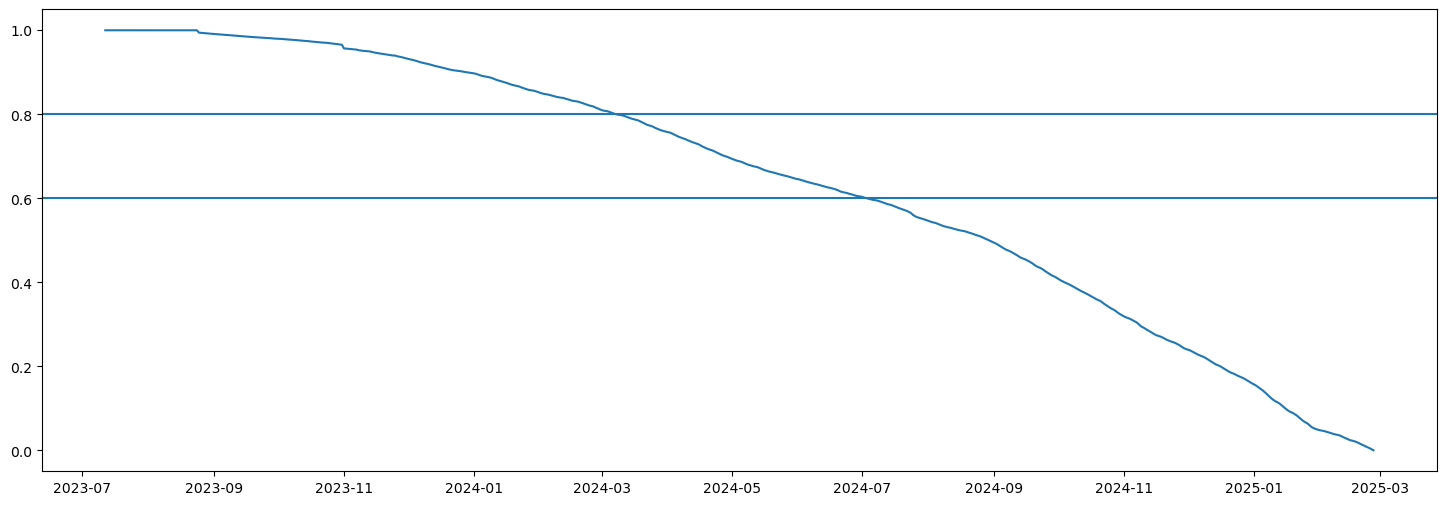

In [283]:
plt.figure(figsize=(18,6))
plt.plot([x[0] for x in holder], [x[1] for x in holder])
plt.axhline(0.8)
plt.axhline(0.6)

In [284]:
deals = pd.read_csv('all-deals.csv', dtype={"Associated Contact IDs":str})


C:\Users\Tal\AppData\Local\Temp\ipykernel_39732\848651372.py:1: DtypeWarning: Columns (5,10) have mixed types. Specify dtype option on import or set low_memory=False.
  deals = pd.read_csv('all-deals.csv', dtype={"Associated Contact IDs":str})


In [286]:
deals = deals[~deals['Associated Contact IDs'].isna()].copy()



In [287]:
deals = deals[~deals['Associated Contact IDs'].str.contains(";")].copy()

In [288]:
deals['Associated Contact IDs'] = deals['Associated Contact IDs'].astype(np.int64)

In [289]:
deals = deals.set_index("Associated Contact IDs")[['Deal owner','Agent of AfA/JC','Deal potential']].copy()

In [290]:
df = df.join(deals, how="left")
df['feat_Deal_owner'] = df['Deal owner'].fillna("unknown")
df['feat_Agent_of_AfA'] = df['Agent of AfA/JC'].str.lower().fillna("unknown")
df['feat_Deal_potential'] = df['Deal potential'].fillna("unknown")

In [204]:
agent = "her bilbl"
print(re.findall(r'her{1,2} ', agent))

['her ']


In [184]:
df = pd.read_pickle('interim_datasets/4 - df_tokenized_version.pkl')

In [267]:
def agent_changer(agent):
    if str(agent) in (".", "tbt", "?","no name","n.a.", "tbd","pending","/","a/a",'-')  or pd.isna(agent):
        return "unknown"
    if agent=="jc" or agent=="jobcenter":
        return "jc"
    return agent.lower().strip()
# df['feat_Agent_of_AfA']

def agent_gender(agent):
    agent = agent.lower()
    
    if "frau "  in agent:
        return "female"
    if len(re.findall(r'her{1,2} ', agent))>0 or agent=="matthias höinghaus":
        return "male"
    return "unknown"


def agent_is_known(agent):
    agent = agent.lower()
    if "frau "  in agent or  'herr ' in agent:
        return "known"
    if agent in ('möcking','adler','köhler','schulz'):
        return "known"
    return "unknown"


def point_out_genders(cols):
    feat_gender, feat_agent_gender = cols
    if 'unknown' in (feat_gender, feat_agent_gender):
        return 'unable to determine'
    
    if feat_gender == feat_agent_gender:
        return "same gender"
    return "not the same"

df['feat_Agent_of_AfA'] = df['Agent of AfA/JC'].apply(agent_changer)
df["feat_agent_gender"] = df['feat_Agent_of_AfA'].apply(agent_gender)
df['feat_same_gender'] = df[['feat_gender', "feat_agent_gender"]].apply(point_out_genders, axis=1)
df['feat_agent_is_known'] = df['feat_Agent_of_AfA'].apply(agent_is_known)


In [271]:
agents_rows = df[['feat_gender', 'Agent of AfA/JC','feat_Agent_of_AfA',
'feat_agent_gender',
'feat_same_gender',
'feat_agent_is_known']].drop_duplicates()



agents_rows.sample(10)



,feat_gender,Agent of AfA/JC,feat_Agent_of_AfA,feat_agent_gender,feat_same_gender,feat_agent_is_known
285688869,female,Herr Ergun,herr ergun,male,not the same,known
95606004654,male,Frau Duday,frau duday,female,not the same,known
48613497013,male,Herr Zioudas,herr zioudas,male,same gender,known
23373122391,male,Frau Widera,frau widera,female,not the same,known
294249482,female,Huan,huan,unknown,unable to determine,unknown
286590762,female,Frau Brander,frau brander,female,same gender,known
216050196,female,.,unknown,unknown,unable to determine,unknown
63950445346,female,Herr Stürzebecher,herr stürzebecher,male,not the same,known
53340964910,male,Herr Gerlach,herr gerlach,male,same gender,known
77752652073,male,Herr Meusel,herr meusel,male,same gender,known


In [304]:
cat_cols = [
    'feat_same_gender',
    "feat_agent_gender",
"feat_age_range",
"feat_employment_situation",
"feat_german_job_permit",
# "feat_finished_completing_profile",
#     "feat_Deal_owner",
"feat_Agent_of_AfA",
"feat_Deal_potential",
# "feat_started_completing_profile",
"feat_completing_profile_rate",
# "feat_completed_last_job",
# "feat_completed_time_worked_in_de",
# "feat_completed_highest_level_of_education",
# "feat_completed_state",
# "feat_completed_how_did_you_hear_about_us",
# "feat_completed_why_do_you_want_to_start_a_career_in_tech",
"feat_eng_level_grouped",
"feat_german_level_grouped",
"feat_form_language",
# "feat_bilingual",
"feat_education_level",
# "feat_education_low",
"feat_in_contact_with_job_advisor",
# "feat_last_job_related",
    "feat_desired_program_length",
"feat_registered_with_the_jobcenter",
"feat_lpvariant",
"feat_utm_source",
"feat_utm_campaign",
"feat_state_in_de",
"feat_unemployment_rate_pct",
"feat_state_specific_funding_policies",
"feat_industry_demand_pct",
"feat_east_west",
    'feat_visa_status',
'feat_work_experience_category',
'feat_field_of_interest',
# 'feat_residents',
'feat_gender',
'feat_1st_country',
'feat_continent',
    'feat_agent_is_known',
]

numerical = [
    'feat_past_success_for_ms',
    'feat_expectation',
    'feat_days_to_mql',
    'feat_hour_projection',
'feat_day_projection',
'feat_month_projection',
'feat_day_of_week_projection',
    'feat_text_length',
'feat_word_count',
'feat_unique_word_count',
'feat_avg_word_length',
'feat_char_count_no_spaces',
'feat_word_density',
'feat_unique_word_ratio',
'feat_sentence_count',
'feat_syllable_count',
# 'feat_punctuations_count',
'feat_complex_word_count',
'feat_syllables_per_word',
'feat_words_per_sentence',
'feat_flesch_reading_ease',
'feat_flesch_kincaid_grade',
'feat_gunning_fog',
'feat_smog_index',
'feat_coleman_liau_index',
'feat_automated_readability_index',
'feat_dale_chall_readability',
#     'feat_requesting_prop'
]




df['closed_won_deal__program_duration'] =  df['closed_won_deal__program_duration'].fillna("fail")

In [305]:
df['requested_bg'].value_counts()



not requested    101737
requested          9964
Name: requested_bg, dtype: int64

In [306]:
df['closed_won_deal__program_duration'].value_counts()

fail         109680
14 Months       957
7 Months        651
8 Months        236
1 Month         177
Name: closed_won_deal__program_duration, dtype: int64

In [307]:
# closed_won_deal__program_duration

target = 'requested_bg'


for col in cat_cols:
    df[col] = df[col].astype(str)

In [308]:
df['mql_date'] = pd.to_datetime(df['mql_date'])

In [316]:
cutoff = '2025-03-01'
cutoff = pd.to_datetime(df['mql_date']).min() + timedelta((pd.to_datetime(df['mql_date']).max()-pd.to_datetime(df['mql_date'].min())).days/2+120)
start_date = "2023-01-01"
future_test = df[(df['mql_date']>=cutoff)].copy()
current_df = df[(df['mql_date']<cutoff) & (df['mql_date']>=start_date)].copy()


final_columns = numerical + cat_cols + [target]


pre_model = current_df.copy()


pre_model = pre_model[final_columns].copy()
pre_model_future = future_test[final_columns].copy()



In [317]:
pd.to_datetime(df['mql_date']).min() + timedelta((pd.to_datetime(df['mql_date']).max()-pd.to_datetime(df['mql_date'].min())).days/2)

Timestamp('2024-05-10 08:21:46.493000+0000', tz='UTC')

In [318]:
pd.to_datetime(df['mql_date']).min() + timedelta((pd.to_datetime(df['mql_date']).max()-pd.to_datetime(df['mql_date'].min())).days/2)

Timestamp('2024-05-10 08:21:46.493000+0000', tz='UTC')

In [319]:
df['mql_date'].max()

Timestamp('2025-03-09 15:23:02.702000+0000', tz='UTC')

In [320]:
pre_model_future[target].value_counts()

not requested    48692
requested         3586
Name: requested_bg, dtype: int64

In [321]:
pre_model[target].value_counts(normalize=True)

not requested    0.892668
requested        0.107332
Name: requested_bg, dtype: float64

In [322]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Assuming you have your dataframe already loaded as current_df with 'requested_bg' target
target = 'requested_bg'

# Check the class distribution
print("Original class distribution:")
print(pre_model[target].value_counts())
print(f"Imbalance ratio: 1:{pre_model[target].value_counts()[0]/pre_model[target].value_counts()[1]:.2f}")

# Identify categorical and numerical columns
categorical_cols = pre_model.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = pre_model.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove target from feature lists if present
if target in categorical_cols:
    categorical_cols.remove(target)
if target in numerical_cols:
    numerical_cols.remove(target)

print(f"\nCategorical columns: {len(categorical_cols)}")
print(f"Numerical columns: {len(numerical_cols)}")

# First, determine if we need to encode the target
if pre_model[target].dtype == 'object' or pre_model[target].dtype.name == 'category':
    # Encode string labels to numbers
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(pre_model[target])
    # Check the mapping
    for i, label in enumerate(label_encoder.classes_):
        print(f"Original: '{label}' → Encoded: {i}")
else:
    # Target is already numeric
    y_encoded = pre_model[target].values

# Split the data
X = pre_model.drop(target, axis=1)
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("\nTrain set class distribution:")
print(Counter(y_train_encoded))

# Define balancing strategies
def balance_with_over_under(X_train, y_train, sampling_strategy_over=0.7, sampling_strategy_under=0.8):
    """
    Balance dataset using RandomOverSampler for minority class and RandomUnderSampler for majority class
    """
    # First oversample the minority class
    over = RandomOverSampler(sampling_strategy=sampling_strategy_over, random_state=42)
    X_over, y_over = over.fit_resample(X_train, y_train)
    
    # Then undersample the majority class
    under = RandomUnderSampler(sampling_strategy=sampling_strategy_under, random_state=42)
    X_balanced, y_balanced = under.fit_resample(X_over, y_over)
    
    return X_balanced, y_balanced

def balance_with_undersampling(X_train, y_train, sampling_strategy=0.5):
    """
    Simple undersampling of majority class
    """
    under = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
    X_balanced, y_balanced = under.fit_resample(X_train, y_train)
    return X_balanced, y_balanced

def calculate_class_weights(y_train):
    """
    Calculate class weights inversely proportional to class frequencies
    """
    class_counts = np.bincount(y_train)
    total_samples = len(y_train)
    weights = {i: total_samples / (len(class_counts) * count) for i, count in enumerate(class_counts)}
    return weights

# Choose a balancing strategy (uncomment one approach)

# Strategy 1: Over-sampling + Under-sampling 
# X_balanced, y_balanced = balance_with_over_under(
#     X_train, y_train_encoded, 
#     sampling_strategy_over=0.15, 
#     sampling_strategy_under=0.6
# )



X_balanced, y_balanced = balance_with_undersampling(
    X_train, y_train_encoded, 
    sampling_strategy=0.6
)
print("\nUsing Strategy 1: Combined over/under sampling")
print("Balanced class distribution:", Counter(y_balanced))
X_balanced= X_train
y_balanced = y_train_encoded


weights = calculate_class_weights(y_balanced)
print(weights)
weights[1]*=0.8
print(weights)


Original class distribution:
not requested    53045
requested         6378
Name: requested_bg, dtype: int64
Imbalance ratio: 1:8.32

Categorical columns: 30
Numerical columns: 26
Original: 'not requested' → Encoded: 0
Original: 'requested' → Encoded: 1

Train set class distribution:
Counter({0: 42436, 1: 5102})

Using Strategy 1: Combined over/under sampling
Balanced class distribution: Counter({0: 8503, 1: 5102})
{0: 0.5601140541050051, 1: 4.658761270090161}
{0: 0.5601140541050051, 1: 3.727009016072129}


In [325]:
# Create CatBoost pools with categorical features
train_pool = Pool(X_balanced, y_balanced, cat_features=categorical_cols)
test_pool = Pool(X_test, y_test_encoded, cat_features=categorical_cols)

# Choose one approach for handling class imbalance:

# Approach 1: Use balanced dataset without class weights in model
model = CatBoostClassifier(
    iterations=25000,
    learning_rate=0.015,
    depth=3,
    l2_leaf_reg=12,
    bootstrap_type='Bernoulli',
    subsample=0.35,
    sampling_frequency ='PerTreeLevel',
    eval_metric='Precision',
    custom_metric=['F1', 'AUC'],
    loss_function='Logloss',
    class_weights=weights,
    use_best_model=True,
    random_seed=42,
    verbose=250,
    random_strength = 5.15,
     od_type='Iter',
    od_wait=7500,         
)


model.fit(train_pool, eval_set=test_pool, plot=True, use_best_model=True)

# Evaluate the model
y_pred = model.predict(test_pool)
y_pred_proba = model.predict_proba(test_pool)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test_encoded, y_pred_proba):.4f}")



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7773588	test: 0.7741238	best: 0.7741238 (0)	total: 56.3ms	remaining: 23m 26s
250:	learn: 0.7890810	test: 0.7842829	best: 0.7914907 (96)	total: 11.7s	remaining: 19m 10s
500:	learn: 0.7814830	test: 0.7767064	best: 0.7914907 (96)	total: 23.5s	remaining: 19m 7s
750:	learn: 0.7799808	test: 0.7754894	best: 0.7914907 (96)	total: 35.5s	remaining: 19m 5s
1000:	learn: 0.7846430	test: 0.7787032	best: 0.7914907 (96)	total: 48.6s	remaining: 19m 24s
1250:	learn: 0.7879278	test: 0.7806986	best: 0.7914907 (96)	total: 1m 1s	remaining: 19m 25s
1500:	learn: 0.7892584	test: 0.7828236	best: 0.7914907 (96)	total: 1m 14s	remaining: 19m 24s
1750:	learn: 0.7907864	test: 0.7842168	best: 0.7914907 (96)	total: 1m 27s	remaining: 19m 15s
2000:	learn: 0.7920789	test: 0.7853944	best: 0.7914907 (96)	total: 1m 39s	remaining: 19m
2250:	learn: 0.7932578	test: 0.7863818	best: 0.7914907 (96)	total: 1m 51s	remaining: 18m 48s
2500:	learn: 0.7947250	test: 0.7868315	best: 0.7914907 (96)	total: 2m 3s	remaining: 18m 

21750:	learn: 0.8510664	test: 0.8261132	best: 0.8264562 (21586)	total: 19m 53s	remaining: 2m 58s
22000:	learn: 0.8513462	test: 0.8260727	best: 0.8266182 (21796)	total: 20m 10s	remaining: 2m 45s
22250:	learn: 0.8519745	test: 0.8266980	best: 0.8268999 (22236)	total: 20m 26s	remaining: 2m 31s
22500:	learn: 0.8526327	test: 0.8277315	best: 0.8277315 (22495)	total: 20m 43s	remaining: 2m 18s
22750:	learn: 0.8529256	test: 0.8282142	best: 0.8282142 (22696)	total: 21m	remaining: 2m 4s
23000:	learn: 0.8535712	test: 0.8284168	best: 0.8284168 (22995)	total: 21m 16s	remaining: 1m 50s
23250:	learn: 0.8542269	test: 0.8278329	best: 0.8285181 (23104)	total: 21m 33s	remaining: 1m 37s
23500:	learn: 0.8544844	test: 0.8283784	best: 0.8285181 (23104)	total: 21m 49s	remaining: 1m 23s
23750:	learn: 0.8548234	test: 0.8292281	best: 0.8292281 (23723)	total: 22m 6s	remaining: 1m 9s
24000:	learn: 0.8555270	test: 0.8287208	best: 0.8292281 (23723)	total: 22m 23s	remaining: 55.9s
24250:	learn: 0.8560959	test: 0.828199

In [326]:
print(confusion_matrix(y_test_encoded, y_pred))

[[9219 1390]
 [ 261 1015]]


In [327]:
# Feature importance
feature_importances = model.get_feature_importance(train_pool)
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=True).reset_index(drop=True)
print("\nTop 10 Important Features:")
importance_df.head(5)


Top 10 Important Features:


,Feature,Importance
0,feat_desired_program_length,0.000000
1,feat_form_language,0.076176
2,feat_state_specific_funding_policies,0.120701
3,feat_complex_word_count,0.122408
4,feat_sentence_count,0.144437


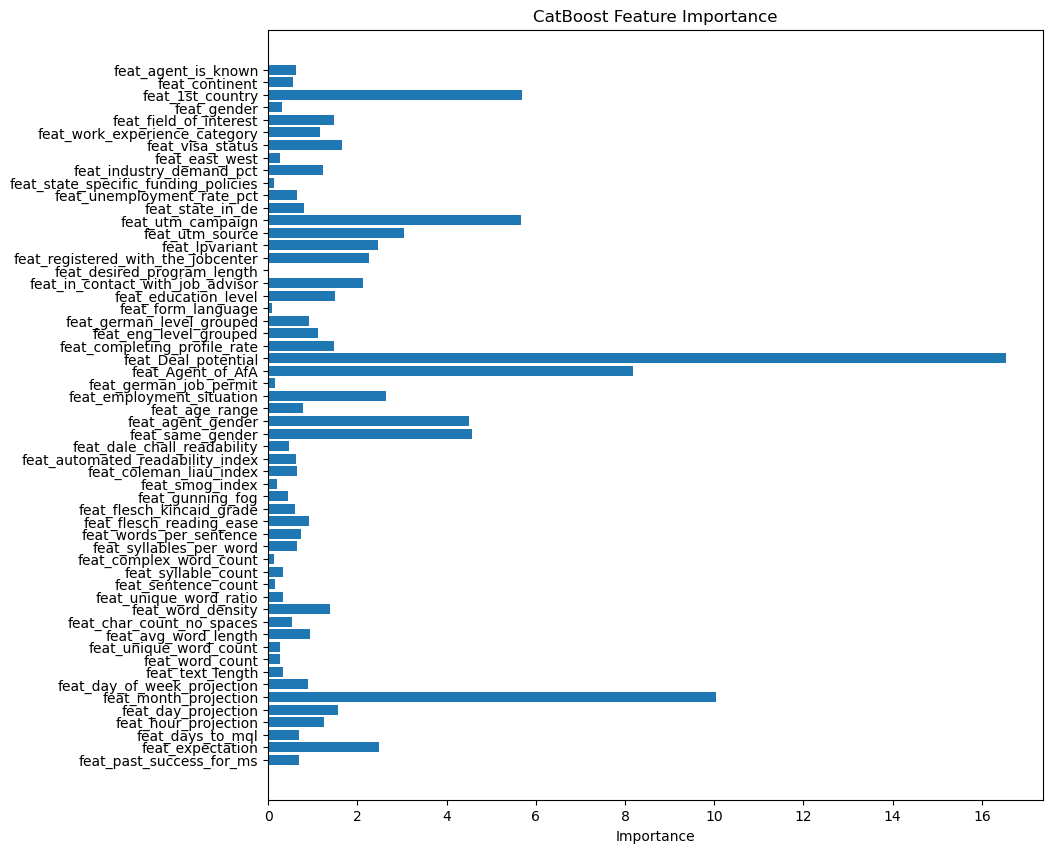

In [328]:
import matplotlib.pyplot as plt

# Get feature importances using the default method (PredictionValuesChange)
feature_importances = model.get_feature_importance(train_pool)
features = X_train.columns

# Visualize the importances
plt.figure(figsize=(10, 10))
plt.barh(features, feature_importances)
plt.xlabel("Importance")
plt.title("CatBoost Feature Importance")
plt.show()


               precision    recall  f1-score   support

not requested       0.99      0.78      0.87     48692
    requested       0.22      0.87      0.35      3586

     accuracy                           0.78     52278
    macro avg       0.61      0.82      0.61     52278
 weighted avg       0.94      0.78      0.83     52278



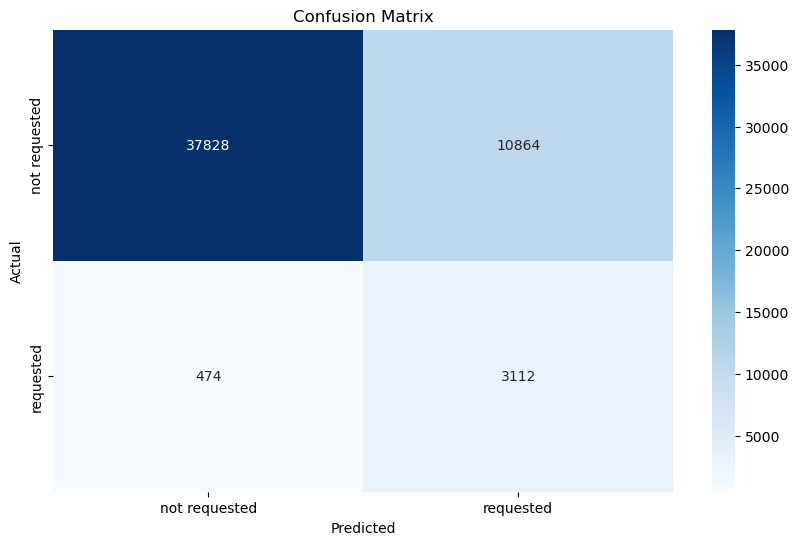

In [329]:
preds = model.predict(pre_model_future.drop('requested_bg', axis=1))

conf_matrix = confusion_matrix(pre_model_future[target], label_encoder.inverse_transform(preds))
print(classification_report(pre_model_future[target], label_encoder.inverse_transform(preds)))


# Get unique class labels
labels = np.unique(label_encoder.inverse_transform(preds))

# Plot confusion matrix with labels
plt.figure(figsize=(10,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

prec = precision_score(y_test_encoded, model.predict(test_pool))
prec

preds.sum()

In [ ]:
from sklearn.metrics import precision_score
final_pool = Pool(pre_model_future.drop('requested_bg', axis=1), label_encoder.transform(pre_model_future['requested_bg']), cat_features=categorical_cols)

y_pred_proba = model.predict_proba(final_pool)[:, 1]
best_threshold = 0
best_precision = 0

# Just a quick brute force example
for t in [x/100 for x in range(1, 100)]:
    preds = (y_pred_proba >= t).astype(int)
    prec = precision_score(label_encoder.transform(pre_model_future['requested_bg']), preds)
    if prec > best_precision:
        best_precision = prec
        best_threshold = t
        best_preds = preds

print(f"Best threshold = {best_threshold}, precision = {best_precision:.4f}, sum(best_preds) = {sum(best_preds)}")


In [ ]:
model.plot_tree(
    tree_idx=2,
    pool=test_pool
)


In [ ]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)
shap_values
# visualize the first prediction's explanation


In [ ]:
shap.plots.force(shap_values[0:100])

In [ ]:
# shap.plots.beeswarm(shap_values, max_display=20, cluster_threshold=0.8)
# If shap_values is an ndarray:


In [ ]:
feature_names = X.columns.tolist()
# or ensure shap_values is a DataFrame


In [ ]:
from sklearn.metrics import precision_score

y_pred_proba = model.predict_proba(test_pool)[:, 1]
best_threshold = 0
best_precision = 0

# Just a quick brute force example
for t in [x/100 for x in range(1, 100)]:
    preds = (y_pred_proba >= t).astype(int)
    prec = precision_score(y_test_encoded, preds)
    if prec > best_precision:
        best_precision = prec
        best_threshold = t
        best_preds = preds

print(f"Best threshold = {best_threshold}, precision = {best_precision:.4f}, sum(best_preds) = {sum(best_preds)}")


In [ ]:
import numpy as np
from sklearn.metrics import f1_score

# Get the predicted probabilities for the positive class
# This assumes your model is a binary classifier
y_valid_probs = y_prob

# Define a range of thresholds to test
thresholds = np.linspace(0, 1, 101)

best_f1 = 0
best_threshold = 0.5

# Loop over each threshold, compute predictions and evaluate F1
for threshold in thresholds:
    # Convert probabilities to binary predictions based on threshold
    y_pred = (y_valid_probs >= threshold).astype(int)
    current_f1 = f1_score(y_valid, y_pred)
    
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_threshold = threshold

print("Best threshold:", best_threshold)
print("Best F1 score:", best_f1)


In [ ]:
confusion_matrix(df_prob['Actual Class'],df_prob['predicted_class'])

In [ ]:
df_prob['Actual Value'] = df_prob['Actual Class'].apply(actual_class_value)

In [ ]:
from sklearn.metrics import mean_squared_error


rmse = np.sqrt(mean_squared_error(df_prob["Actual Value"], df_prob["lead_value"]))
rmse

In [ ]:
df_prob.sort_values('Actual Value')

In [ ]:
df_prob['fixed_lead_value'] = np.where(df_prob['not enrolled']<=0.5, df_prob['1 Month']*3900+df_prob['14 Months']*46000+ df_prob['8 Months']*29600, 0)


In [ ]:

rmse = np.sqrt(mean_squared_error(df_prob["Actual Value"], df_prob["fixed_lead_value"]))
rmse

In [ ]:
# pre_model

In [ ]:
# pre_model[pre_model['requested_bg']=='requested']



In [ ]:
from bayes_opt import BayesianOptimization
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder

# First, encode your string labels to numbers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(pre_model[target])

# Check the mapping
for i, label in enumerate(label_encoder.classes_):
    print(f"Original: '{label}' → Encoded: {i}")

# Split the data using encoded labels
X_train, X_valid, y_train, y_valid = train_test_split(
    pre_model.drop(target, axis=1),
    y_encoded,
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

# Calculate class weights - use the actual class indices now
class_counts = np.bincount(y_encoded)
class_weights = {i: len(y_train) / (len(np.unique(y_encoded)) * count) 
                for i, count in enumerate(class_counts)}


# Create CatBoost Pools for training and validation
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
test_pool = Pool(X_valid, y_valid, cat_features=cat_cols)

def catboost_eval(iterations, learning_rate, depth, l2_leaf_reg, random_strength, border_count, subsample, multiplier):
    """
    This function trains a CatBoost model with the given hyperparameters,
    and returns the F1 score on the validation set.
    """
    # Convert some parameters to integer values
    iterations = int(iterations)
    depth = int(depth)
    border_count = int(border_count)
    
    # Recalculate class weights with the multiplier for the positive class
    class_counts = np.bincount(y_train)
    class_weights = {i: len(y_train) / (len(np.unique(y_train)) * count) 
                    for i, count in enumerate(class_counts)}
    class_weights[1] *= multiplier
    
    params = {
        'iterations': iterations,
        'learning_rate': learning_rate,
        'depth': depth,
        'l2_leaf_reg': l2_leaf_reg,
        'random_strength': random_strength,
        'subsample': subsample,
        'border_count': border_count,
        'loss_function': 'Logloss',
        'eval_metric': 'F1',
        "bootstrap_type": 'Bernoulli',
        'thread_count': 4,
        'od_type': 'Iter',
        'od_wait': 50,
        'random_seed': 42,
        'verbose': False,
        'class_weights': class_weights
    }
    
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=test_pool, use_best_model=True)
    
    # Predict on the validation set (binary classification, so predictions are 0/1)
    preds = model.predict(test_pool)
    score = f1_score(y_valid, preds)
    return score

# Define the boundaries of the hyperparameters
pbounds = {
    'iterations': (200, 10000),
    'learning_rate': (0.0001, 0.25),
    'depth': (2, 12),
    'l2_leaf_reg': (1, 12),
    'random_strength': (1e-9, 10.0),
    'subsample': (0.0, 1.0),
    'border_count': (16, 255),
    'multiplier': (0.75, 5.5)
}

# Set up the Bayesian optimizer to maximize F1 score
optimizer = BayesianOptimization(
    f=catboost_eval,
    pbounds=pbounds,
    random_state=42,
)

# Run the optimizer: 2 random initial points, then 4 iterations
optimizer.maximize(
    init_points=75,
    n_iter=75,
)

# Display the best result found
print("Best result:", optimizer.max)

In [ ]:
# Get the best score found during optimization
best_score = optimizer.max['target']
print(f"Best F1 score found: {best_score:.4f}")

# Get the parameters that produced this score
best_params = optimizer.max['params']
print("Parameters that achieved this score:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc

# Get the best parameters from the optimizer
best_params = optimizer.max['params']
print("Best parameters found:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Convert integer parameters
iterations = int(best_params['iterations'])
depth = int(best_params['depth'])
border_count = int(best_params['border_count'])

# Calculate class weights with the optimized multiplier
class_counts = np.bincount(y_train)
class_weights = {i: len(y_train) / (len(np.unique(y_train)) * count) 
                for i, count in enumerate(class_counts)}
class_weights[1] *= best_params['multiplier']

# Create the final model with the best parameters
final_model = CatBoostClassifier(
    iterations=iterations,
    learning_rate=best_params['learning_rate'],
    depth=depth,
    l2_leaf_reg=best_params['l2_leaf_reg'],
    random_strength=best_params['random_strength'],
    border_count=border_count,
    subsample=best_params['subsample'],
    loss_function='Logloss',
    eval_metric='F1',
    custom_metric=['AUC', 'Precision'],
    bootstrap_type='Bernoulli',
    thread_count=4,
    random_seed=42,
    class_weights=class_weights,
    verbose=False,  # Set to False to avoid cluttering output
)

# Set up a plot for training visualization
plt.figure(figsize=(12, 8))

# Train the final model and capture the metrics for plotting
final_model.fit(
    train_pool, 
    eval_set=test_pool, 
    use_best_model=True,
    plot=True  # Enable CatBoost's built-in plotting
)

# Extract training history
train_metrics = final_model.get_evals_result()

# Plot learning curves
plt.figure(figsize=(15, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_metrics['learn']['Logloss'], label='Train Loss')
plt.plot(train_metrics['validation']['Logloss'], label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Logloss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# F1 score plot
plt.subplot(1, 2, 2)
plt.plot(train_metrics['validation']['F1'], label='Validation F1')
plt.xlabel('Iterations')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('catboost_learning_curves.png')
plt.show()

# Evaluate the model
train_preds = final_model.predict(train_pool)
train_f1 = f1_score(y_train, train_preds)
valid_preds = final_model.predict(test_pool)
valid_f1 = f1_score(y_valid, valid_preds)

print(f"Training F1 score: {train_f1:.4f}")
print(f"Validation F1 score: {valid_f1:.4f}")

# Get classification probabilities
valid_probs = final_model.predict_proba(test_pool)[:, 1]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_valid, valid_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
# plt.savefig('catboost_confusion_matrix.png')
plt.show()

# Get detailed classification report
print("\nClassification Report (Validation):")
print(classification_report(y_valid, valid_preds))

# Plot ROC curve
plt.figure(figsize=(10, 8))
fpr, tpr, _ = roc_curve(y_valid, valid_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
# plt.savefig('catboost_roc_curve.png')
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(10, 8))
precision, recall, _ = precision_recall_curve(y_valid, valid_probs)
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True, alpha=0.3)
# plt.savefig('catboost_precision_recall_curve.png')
plt.show()

# Feature Importance
plt.figure(figsize=(12, 10))
feature_importance = final_model.get_feature_importance(train_pool)
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 8))
top_features = importance_df.head(20)
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 20 Feature Importance')
plt.tight_layout()
# plt.savefig('catboost_feature_importance.png')
plt.show()

# Threshold analysis
thresholds = np.arange(0.1, 1.0, 0.05)
f1_scores = []
precision_scores = []
recall_scores = []

for threshold in thresholds:
    preds_at_threshold = (valid_probs >= threshold).astype(int)
    f1 = f1_score(y_valid, preds_at_threshold)
    precision = precision_score(y_valid, preds_at_threshold)
    recall = recall_score(y_valid, preds_at_threshold)
    
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)

plt.figure(figsize=(12, 8))
plt.plot(thresholds, f1_scores, 'b-', label='F1 Score')
plt.plot(thresholds, precision_scores, 'g-', label='Precision')
plt.plot(thresholds, recall_scores, 'r-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics at Different Thresholds')
plt.legend()
plt.grid(True, alpha=0.3)
# plt.savefig('catboost_threshold_analysis.png')
plt.show()

# Save the model for later use
# final_model.save_model("catboost_optimized_model.cbm")

In [ ]:
preds = final_model.predict(pre_model_future.drop('requested_bg', axis=1))

conf_matrix = confusion_matrix(pre_model_future[target], label_encoder.inverse_transform(preds))
print(classification_report(pre_model_future[target], label_encoder.inverse_transform(preds)))


# Get unique class labels
labels = np.unique(label_encoder.inverse_transform(preds))

# Plot confusion matrix with labels
plt.figure(figsize=(10,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def create_cyclical_features(df, datetime_column, drop_original=True):
    """
    Creates cyclical features from a datetime column and adds a single projection feature.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the datetime column
    datetime_column : str
        Name of the datetime column
    drop_original : bool, default=True
        Whether to drop the original datetime column
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with cyclical features added
    """
    # Make a copy to avoid modifying the original
    df_result = df.copy()
    
    # Convert to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(df_result[datetime_column]):
        df_result[datetime_column] = pd.to_datetime(df_result[datetime_column])
    
    # Extract time components
    df_result['hour'] = df_result[datetime_column].dt.hour
    df_result['day'] = df_result[datetime_column].dt.day
    df_result['month'] = df_result[datetime_column].dt.month
    df_result['day_of_week'] = df_result[datetime_column].dt.dayofweek
    
    # Create cyclical features
    # Hour of day (24-hour cycle)
    df_result['hour_sin'] = np.sin(2 * np.pi * df_result['hour'] / 24)
    df_result['hour_cos'] = np.cos(2 * np.pi * df_result['hour'] / 24)
    df_result['hour_projection'] = (df_result['hour_sin'] + df_result['hour_cos']) / np.sqrt(2)
    
    # Day of month (assuming 31 days max)
    df_result['day_sin'] = np.sin(2 * np.pi * df_result['day'] / 31)
    df_result['day_cos'] = np.cos(2 * np.pi * df_result['day'] / 31)
    df_result['day_projection'] = (df_result['day_sin'] + df_result['day_cos']) / np.sqrt(2)
    
    # Month of year (12-month cycle)
    df_result['month_sin'] = np.sin(2 * np.pi * df_result['month'] / 12)
    df_result['month_cos'] = np.cos(2 * np.pi * df_result['month'] / 12)
    df_result['month_projection'] = (df_result['month_sin'] + df_result['month_cos']) / np.sqrt(2)
    
    # Day of week (7-day cycle)
    df_result['day_of_week_sin'] = np.sin(2 * np.pi * df_result['day_of_week'] / 7)
    df_result['day_of_week_cos'] = np.cos(2 * np.pi * df_result['day_of_week'] / 7)
    df_result['day_of_week_projection'] = (df_result['day_of_week_sin'] + df_result['day_of_week_cos']) / np.sqrt(2)
    
    # Drop intermediate columns if needed
    if drop_original:
        df_result = df_result.drop([datetime_column, 'hour', 'day', 'month', 'day_of_week'], axis=1)
    
    return df_result

def visualize_cyclical_features(df, time_unit, n_samples=100):
    """
    Visualizes the cyclical features for a specific time unit.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the cyclical features
    time_unit : str
        Time unit to visualize ('hour', 'day', 'month', or 'day_of_week')
    n_samples : int, default=100
        Number of samples to use for visualization
    """
    if len(df) > n_samples:
        sample_df = df.sample(n_samples)
    else:
        sample_df = df
    
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Sin and Cos components
    plt.subplot(2, 2, 1)
    plt.scatter(sample_df[f'{time_unit}_sin'], sample_df[f'{time_unit}_cos'], alpha=0.6)
    plt.title(f'{time_unit.capitalize()} - Sin vs Cos')
    plt.xlabel(f'{time_unit}_sin')
    plt.ylabel(f'{time_unit}_cos')
    plt.grid(True)
    
    # Plot 2: Projection vs original value (if available)
    if time_unit in sample_df.columns:
        plt.subplot(2, 2, 2)
        plt.scatter(sample_df[time_unit], sample_df[f'{time_unit}_projection'], alpha=0.6)
        plt.title(f'{time_unit.capitalize()} vs Projection')
        plt.xlabel(time_unit)
        plt.ylabel(f'{time_unit}_projection')
        plt.grid(True)
    
    # Plot 3: Circle diagram
    circle = plt.subplot(2, 2, 3, polar=True)
    if time_unit in sample_df.columns:
        angle = sample_df[time_unit].values
        if time_unit == 'hour':
            max_val = 24
        elif time_unit == 'day':
            max_val = 31
        elif time_unit == 'month':
            max_val = 12
        elif time_unit == 'day_of_week':
            max_val = 7
        else:
            max_val = 1
        angle = 2 * np.pi * angle / max_val
    else:
        angle = np.arctan2(sample_df[f'{time_unit}_sin'], sample_df[f'{time_unit}_cos'])
    plt.scatter(angle, np.ones_like(angle), alpha=0.6)
    plt.title(f'{time_unit.capitalize()} - Circular Representation')
    
    # Plot 4: Projection distribution
    plt.subplot(2, 2, 4)
    plt.hist(sample_df[f'{time_unit}_projection'], bins=20)
    plt.title(f'{time_unit.capitalize()} - Projection Distribution')
    plt.xlabel(f'{time_unit}_projection')
    plt.ylabel('Frequency')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Create sample data
    dates = pd.date_range(start='2023-01-01', end='2023-12-31', freq='H')
    df_ = pd.DataFrame({'timestamp': dates})
    
    # Create cyclical features
    df_cyclical = create_cyclical_features(df_, 'timestamp', drop_original=False)
    
    # Visualize the features
    visualize_cyclical_features(df_cyclical, 'hour')
    visualize_cyclical_features(df_cyclical, 'day')
    visualize_cyclical_features(df_cyclical, 'month')
    visualize_cyclical_features(df_cyclical, 'day_of_week')
    
    # Print the first few rows to see the features
    print(df_cyclical.head())

In [ ]:
df.columns

In [ ]:
df['employment_situation'].value_counts()

In [ ]:
df.head()